In [6]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist

import jax
import jax.numpy as jnp

from dynamics import QQT, QQTDiagonal
from utils import balanced_weights
from tools import BlindColours, zero_balanced_weights

In [7]:
bc = BlindColours()
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()

In [11]:
np.random.seed(1)

in_dim = 4
hidden_dim = 6
out_dim = 4
batch_size = 16

learning_rate = 0.05
training_steps_ = [2000, 8000]

training, validation, _ = gs.datasets.ReversalLearning(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])

init_w1, init_w2, _, _= balanced_weights(in_dim, hidden_dim, out_dim, 0.25)
w1_init, w2_init = gs.init.FromFixedValue(init_w1), gs.init.FromFixedValue(init_w2)

network_function = []
analytical = []

for i, training_data in enumerate([training, validation]):
    training_steps = training_steps_[i]
    
    if i > 0:
        w1_init = gs.init.FromFixedValue(params["network"]["layer-0"]["w"][0])
        w2_init = gs.init.FromFixedValue(params["network"]["layer-1"]["w"][0])
        
    X, Y = training_data(None)

    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss_fnct = gs.MeanSquaredError()

    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=w1_init),
        gs.Linear(out_dim, bias=False, weight_init=w2_init)
    ])

    trainer = gs.Trainer(task, mlp, loss_fnct, optimiser)
    state, params = gs.assemble(1)

    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    network_function.append(w2 @ w1)

    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        w2w1_, w1w1_, w2w2_ = logs(params, X, Y, out_dim)
        network_function.append(w2w1_)
    
    if i == 1:
        qqt = QQTDiagonal(w1, w2, X.T, Y.T)
        for _ in range(training_steps):
            w2w1 = qqt.forward(learning_rate)[:in_dim, out_dim:] if i == 0 else qqt.forward(learning_rate)
            analytical.append(w2w1)
    
analytical = np.asarray(analytical).reshape(-1, 4*4)

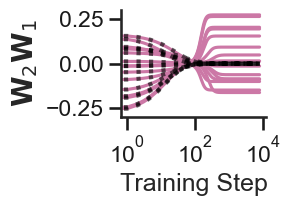

In [12]:
fig, ax = plt.subplots(figsize=(3.1, 2.4))
ax.plot(np.asarray(network_function).reshape(-1, in_dim * out_dim)[-(training_steps+1):], c=blind_colours[3]);
ax.plot(analytical, lw=3., c="k", alpha=0.6, linestyle=(0, (1, 2)))
ax.set_xscale("log")
ax.set_xlabel("Training Step")
ax.set_ylabel("${\\bf W}_2{\\bf W}_1$", fontsize=20)
ax.set_xticks([1, 100, 10000])
sns.despine()
fig.tight_layout()
fig.savefig("./figures/figure-6_a.svg")

In [13]:
np.random.seed(1)
training_steps_ = [400, 400]

w1_init = gs.init.Normal(0., 0.3)

w1s = []
losses = []
analytical = []

for i, training_data in enumerate([training, validation]):
    training_steps = training_steps_[i]
    
    if i > 0:
        w1_init = gs.init.FromFixedValue(params["network"]["layer-0"]["w"][0])
        
    X, Y = training_data(None)

    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss_fnct = gs.MeanSquaredError()

    mlp = gs.Network([
        gs.Linear(out_dim, bias=False, weight_init=w1_init)
    ])

    trainer = gs.Trainer(task, mlp, loss_fnct, optimiser)
    state, params = gs.assemble(1)

    w1 = params["network"]["layer-0"]["w"][0]
    w1s.append(w1)

    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        w1s.append(params["network"]["layer-0"]["w"][0])

In [14]:
analytical = []

U, S, VT = np.linalg.svd(w1)
X, Y = validation(None)
sigma_yx = 1. / batch_size * Y.T @ X

ks = np.diag(U.T @ sigma_yx @ VT.T)
tau = 1. /  learning_rate
b0s = np.diag(U.T @ w1 @ VT.T)
bs = np.asarray([ks * (1. - np.exp(-t / tau)) + b0s * np.exp(-t / tau) for t in range(training_steps_[1])])

analytical = []
for t in range(training_steps_[1]):
    analytical.append(U @ np.diag(bs[t]) @ VT)

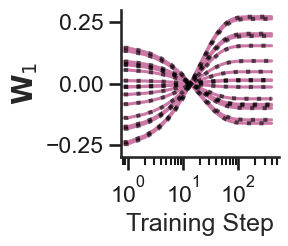

In [15]:
fig, ax = plt.subplots(figsize=(3.1, 2.8))
ax.plot(np.asarray(w1s).reshape(-1, 4*4)[(-training_steps-1):], c=blind_colours[3]);
ax.plot(np.asarray(analytical).reshape(-1, 4*4), lw=3., c="k", alpha=0.6, linestyle=(0, (1, 2)))
ax.set_xscale("log")
ax.set_xlabel("Training Step")
ax.set_ylabel("${\\bf W}_1$", fontsize=20)
sns.despine()
fig.tight_layout()
fig.savefig("./figures/figure-6_b.svg")

In [16]:
np.random.seed(1)

in_dim = 8
hidden_dim = 14
out_dim = 8

learning_rate = 0.05
training_steps_ = [2000, 500]

task_list = [
    (gs.datasets.Hierarchy(False, True)[0], gs.datasets.Hierarchy(True, True)[0]),
    (gs.datasets.Hierarchy(False, True)[0], gs.datasets.ColourHierarchy(True)[0])
]

logs = jax.jit(logs)

network_functions = []
lossess = []
analyticals = []

for h, (sigma, (training_data_1, training_data_2)) in enumerate(zip([0.001, .35], task_list)):
    training_steps = training_steps_[h]
    np.random.seed(1)
    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, sigma)
    w1_init, w2_init = gs.init.FromFixedValue(init_w1), gs.init.FromFixedValue(init_w2)

    network_function = []
    losses = []
    analytical = []

    for i, training_data in enumerate([training_data_1, training_data_2]):
        if i > 0:
            w1_init = gs.init.FromFixedValue(params["network"]["layer-0"]["w"][0])
            w2_init = gs.init.FromFixedValue(params["network"]["layer-1"]["w"][0])

        X, Y = training_data(None)

        task = gs.tasks.FullBatchLearning(training_data)
        optimiser = gs.GradientDescent(learning_rate)
        loss_fnct = gs.MeanSquaredError()

        mlp = gs.Network([
            gs.Linear(hidden_dim, bias=False, weight_init=w1_init),
            gs.Linear(out_dim, bias=False, weight_init=w2_init)
        ])

        trainer = gs.Trainer(task, mlp, loss_fnct, optimiser)
        state, params = gs.assemble(1)

        w1 = params["network"]["layer-0"]["w"][0]
        w2 = params["network"]["layer-1"]["w"][0]
        network_function.append(w2 @ w1)

        for training_step in range(training_steps):
            state, params, loss = trainer(state, params)
            w2w1_, _, _ = logs(params, X, Y, out_dim)
            network_function.append(w2w1_)
            losses.append(1./8. * float(loss[0]))
        
        if h == 0 and i == 1:
            qqt = QQTDiagonal(w1, w2, X.T, 8. * Y.T)
        else:
            qqt = QQT(w1, w2, X.T, 8. * Y.T)
        for _ in range(training_steps):
            qqt_out = qqt.forward(learning_rate / 8.)
            if qqt_out.shape[-1] == 16:
                qqt_out = qqt_out[8:, :8]
            analytical.append(np.asarray(qqt_out))
    
    network_functions.append(network_function)
    lossess.append(losses)
    analyticals.append(analytical)

In [17]:
mdss = []
for i, network_function in enumerate(network_functions):
    step_size = 40 if i == 0 else 10
    w2w1 = np.asarray(network_function)[::step_size, :, :].swapaxes(1, 2).reshape(-1, out_dim)    
    similarities = squareform(pdist(w2w1, "euclidean"))
    embedding = MDS(n_components=2, dissimilarity="precomputed", eps=0.0001, n_jobs=4, random_state=1)
    # embedding = MDS(n_components=2, dissimilarity="precomputed", eps=0.0001, n_jobs=4, random_state=1, normalized_stress="auto")
    mdss.append(embedding.fit_transform(similarities))

/Users/nicolasanguita/miniforge3/envs/dgl-env/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/nicolasanguita/miniforge3/envs/dgl-env/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Users/nicolasanguita/miniforge3/envs/dgl-env/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


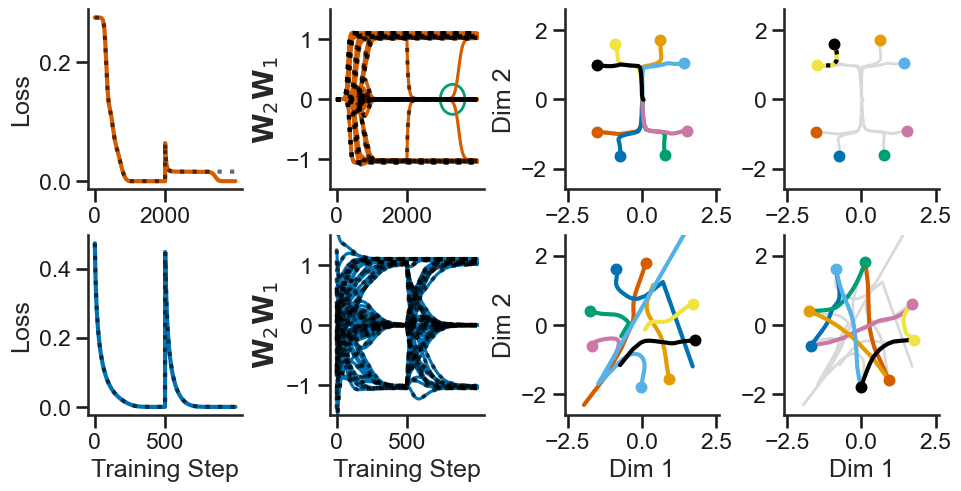

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(9.5, 4.8), constrained_layout=True)

axs = axs.T.flatten()
for i, loss in enumerate(lossess):
    ax = axs[i]
    ax.plot(loss, c=blind_colours[i], lw=3., label="Simulation")
    ax.set_xticks([0, training_steps_[i]])
    if i != 0:
        ax.set_xlabel("Training Step")
    ax.set_ylabel("Loss")

for i, (t1, t2) in enumerate(task_list):
    ax = axs[i]
    Y1 = t1(None)[1].T.reshape(1, 8*8)
    Y2 = t2(None)[1].T.reshape(1, 8*8)
    analytical = np.asarray(analyticals[i]).reshape(-1, 8*8)
    loss1 = .5 * np.mean((analytical - Y1)**2, axis=1)
    loss2 = .5 * np.mean((analytical - Y2)**2, axis=1)
    loss = np.concatenate([loss1[:training_steps_[i]], loss2[training_steps_[i]:]])
    ax.plot(loss, c="k", alpha=0.6, linestyle=(0, (1, 2)), label="Analytical", lw=3.)

for i in range(2):
    ax = axs[i+2]
    ax.plot(np.asarray(network_functions[i]).reshape(-1, 8*8), c=blind_colours[i])
    ax.plot(np.asarray(analyticals[i]).reshape(-1, 8*8), c="k", alpha=0.6, linestyle=(0, (1, 2)), lw=3)
    ax.set_xticks([0, training_steps_[i]])
    ax.set_ylabel("${\\bf W}_2{\\bf W}_1$", fontsize=20)
    if i == 1:
        ax.set_xlabel("Training Step")
    ax.set_ylim(-1.5, 1.5)
    
    if i == 0:
        circ = mpl.patches.Ellipse((3300, 0), height=0.5, width=700., edgecolor=blind_colours[2], fc="None", lw=2.)
        ax.add_patch(circ)
    
for i, mds in enumerate(mdss):
    mds = mds.reshape(-1, 8, 2)
    for half in range(2):
        ax = axs[i + 4 + half * 2]
        start = 0 if half == 0 else (mds.shape[0] // 2) -1
        end = mds.shape[0] // 2 if half == 0 else mds.shape[0]
        t = mds[start:end]
        if i == 0:
            theta = np.deg2rad(310)
        else:
            theta = np.deg2rad(10)
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        t = t @ rot

        b = np.sqrt(np.linspace(1., .001, t.shape[0]))
        for j in range(8):
            if i == 0 and half == 1 and j == 7:
                ax.plot(t[:, j, 0], t[:, j, 1], color=blind_colours[j], lw=3., zorder=4, linestyle=(0, (1, 1.25)))            
            else:
                ax.plot(t[:, j, 0], t[:, j, 1], color=blind_colours[j], lw=3., zorder=4)
            ax.scatter(t[-1, j, 0], t[-1, j, 1], color=blind_colours[j], zorder=5, s=50)
            if not half:
                axs[i + 6].plot(t[:, j, 0], t[:, j, 1], color=(0.85, 0.85, 0.85), lw=2., zorder=3)

        lim = 2.6
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        if i == 1:
            ax.set_xlabel("Dim 1")
        if half == 0:
            ax.set_ylabel("Dim 2")
            
sns.despine()
fig.savefig("./figures/figure-6_e-f-g-h.svg")